In [1]:
!pip install langchain
#!pip install chromadb
!pip install -U langchain-chroma
!pip install pypdf
!pip install pytest
!pip install ollama

In [1]:
import argparse
import os
import shutil
from langchain.document_loaders.pdf import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.schema.document import Document
#from get_embedding_function import get_embedding_function
from langchain.vectorstores.chroma import Chroma

CHROMA_PATH = "chroma"

In [7]:
document_loader = PyPDFDirectoryLoader("documents")
documents = document_loader.load()
print(documents[1])

entry 27 in Xref table invalid but object found


page_content='Neuron, Vol. 36, 585–596, November 14, 2002, Copyright 2002 by Cell Press
The Unfolded Protein Response Modulates
Disease Severity in Pelizaeus-Merzbacher Disease
an X-linked recessive pediatric disorder characterized
by three common genetic forms of disease: coding re-gion or splice site mutations, duplications of the wild-Cherie M. Southwood,
1James Garbern,1,3
Wei Jiang,1and Alexander Gow1,2,3,4
1Center for Molecular Medicine and Genetics
type PLP1 gene, and null alleles. These mutations yield2Department of Pediatrics
a broad spectrum of disease phenotypes from severe,3Department of Neurology
connatal disease to mild forms characterized by pure Wayne State University School of Medicine
spastic paraparesis (reviewed in Garbern et al., 1999; Detroit, Michigan 48201
Southwood and Gow, 2001). Mutant alleles that model
all three of these genetic forms of PMD are available inmice, including (1) myelin synthesis-deficient (msd), an Summary
A242V missense mutation causing sev

In [8]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1400,
    chunk_overlap=100,
    length_function=len,
    is_separator_regex=False,
)

chunks = text_splitter.split_documents(documents)
print(chunks[2])

page_content='tients (Kobayashi et al., 1994; Schneider et al., 1992); repression. Herein, we demonstrate UPR activation
(2)4e-Plp , comprising supernumerary copies of a 40 kb in the leukodystrophy Pelizaeus-Merzbacher disease
wild-type Plp1 transgene causing overexpression (Ka- (PMD) as well as in three mouse models of this disease
gawa et al., 1994); and (3) Plp1 null (Klugmann et al., and transfected fibroblasts expressing mutant protein.
1997; Rosenbluth et al., 1996; Stecca et al., 2000). Dis- The CHOP protein, widely known as a proapoptotic
ease in msd mice is apparent by 12 days postnatal (P12) transcription factor, modulates pathogenesis in the
as moderate tremors, which rapidly progress through mouse models of PMD; however, this protein exhibits
severe tremors to seizures causing death by 3–4 weeks. antiapoptotic activity. Together, these data show that
On the other hand, rshmice develop symptoms by P14– the UPR has the potential to modulate disease severity
16, exhibit modera

In [4]:
from langchain_community.embeddings import OllamaEmbeddings

ollama_emb = OllamaEmbeddings(model="llama3")

In [9]:
#CHatGPT
from langchain_chroma import Chroma

db = Chroma(persist_directory=CHROMA_PATH, embedding_function=ollama_emb)

last_page_id = None
current_chunk_index = 0

for chunk in chunks:
    source = chunk.metadata.get("source")
    page = chunk.metadata.get("page")
    current_page_id = f"{source}:{page}"

    # If the page ID is the same as the last one, increment the index.
    if current_page_id == last_page_id:
        current_chunk_index += 1
    else:
        current_chunk_index = 0

    # Calculate the chunk ID.
    chunk_id = f"{current_page_id}:{current_chunk_index}"
    last_page_id = current_page_id

    # Add it to the page meta-data.
    chunk.metadata["id"] = chunk_id

# Calculate Page IDs.
chunks_with_ids = chunks

# Add or Update the documents.
existing_items = db.get(include=[])  # IDs are always included by default
existing_ids = set(existing_items["ids"])
print(f"Number of existing documents in DB: {len(existing_ids)}")

# Only add documents that don't exist in the DB.
new_chunks = [chunk for chunk in chunks_with_ids if chunk.metadata["id"] not in existing_ids]

# Batch processing
BATCH_SIZE = 1000
try:
    if len(new_chunks):
        print(f"👉 Adding new documents: {len(new_chunks)}")
        for start in range(0, len(new_chunks), BATCH_SIZE):
            batch = new_chunks[start:start + BATCH_SIZE]
            batch_ids = [chunk.metadata["id"] for chunk in batch]
            db.add_documents(batch, ids=batch_ids)
        print("✅ New documents added successfully")
    else:
        print("✅ No new documents to add")
except Exception as e:
    print(f"Error occurred during ingestion: {e}")


Number of existing documents in DB: 2028
👉 Adding new documents: 239
✅ New documents added successfully


In [6]:
import time
from langchain_chroma import Chroma
from sklearn.decomposition import PCA
import numpy as np

# Initialize ChromaDB
db = Chroma(persist_directory=CHROMA_PATH, embedding_function=ollama_emb)

# Perform PCA on the embeddings before adding them to ChromaDB
def apply_pca(embeddings, n_components=50):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings

# Start time measurement
start_time = time.time()

last_page_id = None
current_chunk_index = 0
embeddings = []  # Store original embeddings for PCA later
chunk_metadata = []  # Store metadata to later add to ChromaDB

# Iterate over chunks
for chunk in chunks:
    source = chunk.metadata.get("source")
    page = chunk.metadata.get("page")
    current_page_id = f"{source}:{page}"

    # If the page ID is the same as the last one, increment the index.
    if current_page_id == last_page_id:
        current_chunk_index += 1
    else:
        current_chunk_index = 0

    # Calculate the chunk ID.
    chunk_id = f"{current_page_id}:{current_chunk_index}"
    last_page_id = current_page_id

    # Add the ID to the chunk metadata
    chunk.metadata["id"] = chunk_id
    chunk_metadata.append(chunk.metadata)

    # Get the embedding for this chunk
    embedding = ollama_emb(chunk.page_content)
    embeddings.append(embedding)

# Apply PCA to reduce embeddings
embeddings = np.array(embeddings)
reduced_embeddings = apply_pca(embeddings, n_components=50)

# Add or Update the documents in ChromaDB
existing_items = db.get(include=[])  # IDs are always included by default
existing_ids = set(existing_items["ids"])
print(f"Number of existing documents in DB: {len(existing_ids)}")

# Only add documents that don't exist in the DB.
new_chunks = [chunk for chunk in chunks if chunk.metadata["id"] not in existing_ids]
new_embeddings = [reduced_embeddings[i] for i, chunk in enumerate(chunks) if chunk.metadata["id"] not in existing_ids]

# Batch processing
BATCH_SIZE = 1000
try:
    if len(new_chunks):
        print(f"👉 Adding new documents: {len(new_chunks)}")
        for start in range(0, len(new_chunks), BATCH_SIZE):
            batch = new_chunks[start:start + BATCH_SIZE]
            batch_embeddings = new_embeddings[start:start + BATCH_SIZE]
            batch_ids = [chunk.metadata["id"] for chunk in batch]
            # Add the documents to the database with PCA-reduced embeddings
            db.add_documents(batch, embeddings=batch_embeddings, ids=batch_ids)
        print("✅ New documents added successfully")
    else:
        print("✅ No new documents to add")
except Exception as e:
    print(f"Error occurred during ingestion: {e}")

# End time measurement
end_time = time.time()

# Calculate and print the time taken
time_taken = end_time - start_time
print(f"⏱️ Time taken for document ingestion: {time_taken:.2f} seconds")

TypeError: 'OllamaEmbeddings' object is not callable

In [10]:
from langchain.prompts import ChatPromptTemplate
from langchain_community.llms.ollama import Ollama

PROMPT_TEMPLATE = """
Answer the question based only on the following context:

{context}

---

Answer the question based on the above context: {question}
"""

question="How does plp1 mutations relate with diseases?"
#question="Do you know how chromosome affects Fabry's disease?"
#question="Is X chromosome and 22 the same?"
#expected_response="Holland or Chile."

# Prepare the DB.
#db = Chroma(persist_directory=CHROMA_PATH, embedding_function=ollama_emb)

# Search the DB.
results = db.similarity_search_with_score(question, k=8)

context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
prompt = prompt_template.format(context=context_text, question=question)
# print(prompt)

model = Ollama(model="llama3")
response_text = model.invoke(prompt)

sources = [doc.metadata.get("id", None) for doc, _score in results]
formatted_response = f"Response: {response_text}\nSources: {sources}"

print(formatted_response)

Response: There is no mention of "plp1" in the provided context, so it's not possible to determine how plp1 mutations relate with diseases based on this information. The text appears to be a collection of scientific articles and references related to genetics, genomics, and disease research, but does not specifically discuss plp1 or its relationship to disease.
Sources: ['documents/The DNA sequence of the human X chromosome - PMC.pdf:24:1', 'documents/The DNA sequence of the human X chromosome - PMC.pdf:27:0', 'documents/The DNA sequence of the human X chromosome - PMC.pdf:26:0', 'documents/biomolecules-11-00271.pdf:14:2', 'documents/The DNA sequence of the human X chromosome - PMC.pdf:25:0', 'documents/biomolecules-11-00271.pdf:15:4', 'documents/jcm-07-00342.pdf:12:3', 'documents/The DNA sequence of the human X chromosome - PMC.pdf:26:1']


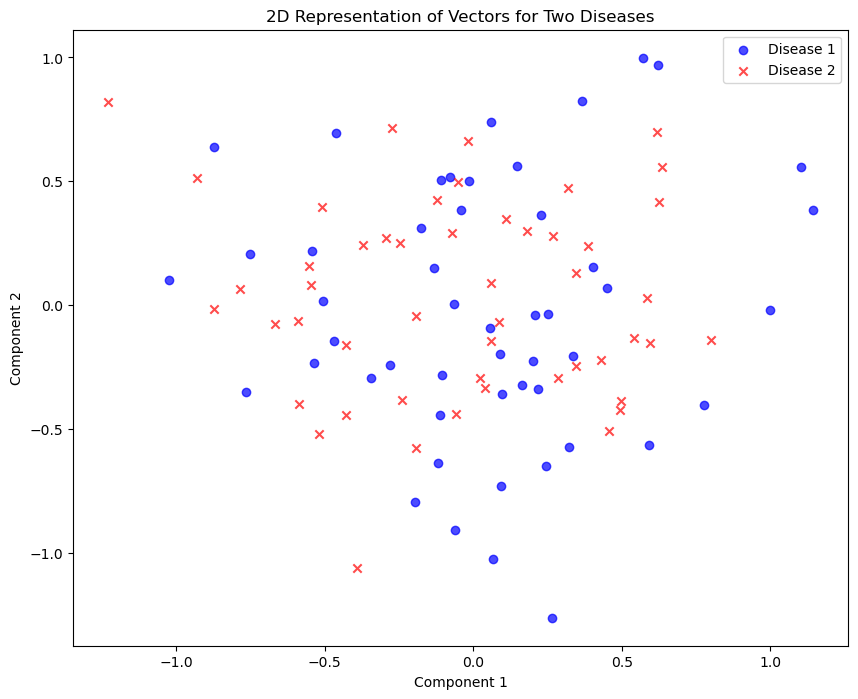

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Sample data
# Replace these with your actual vectors from ChromaDB
def get_disease_vectors():
    # Simulate data for two diseases
    # Disease 1: 50 samples, 50 dimensions
    # Disease 2: 50 samples, 50 dimensions
    disease1_vectors = np.random.rand(50, 50)
    disease2_vectors = np.random.rand(50, 50)
    return disease1_vectors, disease2_vectors

# Get vectors for both diseases
disease1_vectors, disease2_vectors = get_disease_vectors()

# Combine vectors for dimensionality reduction
all_vectors = np.vstack([disease1_vectors, disease2_vectors])

# Reduce dimensionality to 2D
def reduce_dimensionality(vectors, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    
    reduced_vectors = reducer.fit_transform(vectors)
    return reduced_vectors

reduced_vectors = reduce_dimensionality(all_vectors, method='pca')

# Split reduced vectors for plotting
reduced_disease1 = reduced_vectors[:len(disease1_vectors)]
reduced_disease2 = reduced_vectors[len(disease1_vectors):]

# Plot the vectors
plt.figure(figsize=(10, 8))
plt.scatter(reduced_disease1[:, 0], reduced_disease1[:, 1], color='blue', label='Disease 1', alpha=0.7, marker='o')
plt.scatter(reduced_disease2[:, 0], reduced_disease2[:, 1], color='red', label='Disease 2', alpha=0.7, marker='x')
plt.title('2D Representation of Vectors for Two Diseases')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

